# AI4IA Hackathon Phase 1: présentation du DataSet et exemple.s de prédiction

# Description:

Ce Notebook est mis à disposition des candidats du Challenge AI4IA-1ere Edition et est exclusivement dédié à cet évènement.

Le but de cet exemple classique est d'aider à la compréhension de ce qui est attendu des candidats, d'introduire les outils mis à disposition ainsi que les jeux de données et leur format. 

Les éléments fournis sont les suivants:
- jeu de données d'exemple (./data/DataSet_ex) sous la forme de plusieurs fichiers .csv, chacun correspondant à un signal d'excitation ;
- fichiers de définition des modèles et de leurs interfaces (cf. model_api.py et les exemples my_model1.py / my_model2.py). Note: le fichier de définition des modèles est la principale soumission des candidats: c'est à ce niveau qu'il est demandé d'implémenter l'architecture du modèle, ainsi que les stratégies d'inférence et d'entrainement;
- script générique pour le lancement d'un entraînement sur une instance AWS via sagemaker ou en local (sagemajer_api.py);
- scripts génériques pour l'évaluation des performances du modèle sur une instance AWS via sagemaker ou en local telles que définies pas les évaluateurs (les mêmes critères d'évaluation/métriques seront appliquées durant la phase d'évalutation, en considérant un jeu de données identique pour chaque candidat ainsi qu'une machine/instance AWS identique);
- une classe de test unitaire (cf. test_submission.py) permettant à tout instant de tester si la solution développée (la définition du modèle notamment) est conforme à ce qui est attendu et à ce qui sera mis en oeuvre lors de la phase d'évaluation. 

Note: il est donc indispensable que le modèle soumis par l'équipe candidate valide tous les tests unitaires et présente les caractéristiques nécessaires à l'évaluation de ses performances sur des instances AWS avec un fichier de test csv arbitraire (via calc_metrics_on_sagemaker.py). Il est donc vivement recommandé de s'assurer que le modèle développé présente bien ces caractéristiques.

Author: François Caire \
Maintainer: François Caire \
Email: francois.caire at skf.com 

Exposés : Soutenances de projet (8 ou 15 novembre) :

Compte-tenu du nombre d'élèves et de groupes, nous allons devoir limiter strictement la durée des exposés et questions réponses : vous disposerez de 4 minutes strictes pour l'exposé, suivi de max 3 minutes de questions/réponses/commentaires. Dans votre exposé (4 à 5 slides maximum), vous aborderez les points suivants 

- problème abordé, nature des données

- question posée

- "features" introduits ou utilisés

- méthodes utilisées, résultats obtenus

- comparaison

- enseignements (performances, implantation, difficultés rencontrées, perspectives)

# Sommaire :
1. [Chargement des Modules](#1-bullet)
2. [Chargement et exploration du DataSet](#2-bullet)
3. [Exemple Rudimentaire d'apprentissage](#3-bullet)
4. [Entraînement sur AWS SageMaker](#4-bullet)
5. [Evaluation de la solution en local et AWS SageMaker](#5-bullet)

# 1. Chargement des Modules <a class="anchor" id="1-bullet"></a>

Ici on importe les modules classiques

In [125]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%aimport -sg -mpl -plt -notebook -np -integrate -torch -TensorDataset -DataLoader

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


On ajoute des paramètres d'affichage et de tracé...

In [126]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2.0

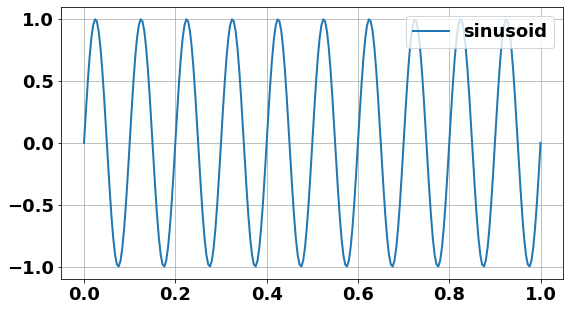

In [127]:
t=np.linspace(0,1,251)
y=np.sin(t*10*2*np.pi)

plt.figure(figsize=(9,5))
plt.plot(t,y,label='sinusoid')
plt.legend(loc='upper right')
plt.grid()
plt.show()


# 2. Chargement et Exploration/Tracé du DataSet d'exemple <a class="anchor" id="2-bullet"></a>

In [128]:
rep_data = "./data/DataSet_ex/"
names = ["input"+str(k) for k in range(1,6)]

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

In [129]:
d['input1'].head()

,Time,input,output1,output2,output3,output4,output5
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.014892,0.0,0.0,0.0,0.0,0.0,0.0
2,0.029784,0.0,0.0,0.0,0.0,0.0,0.0
3,0.044676,0.0,0.0,0.0,0.0,0.0,0.0
4,0.059568,0.0,0.0,0.0,0.0,0.0,0.0


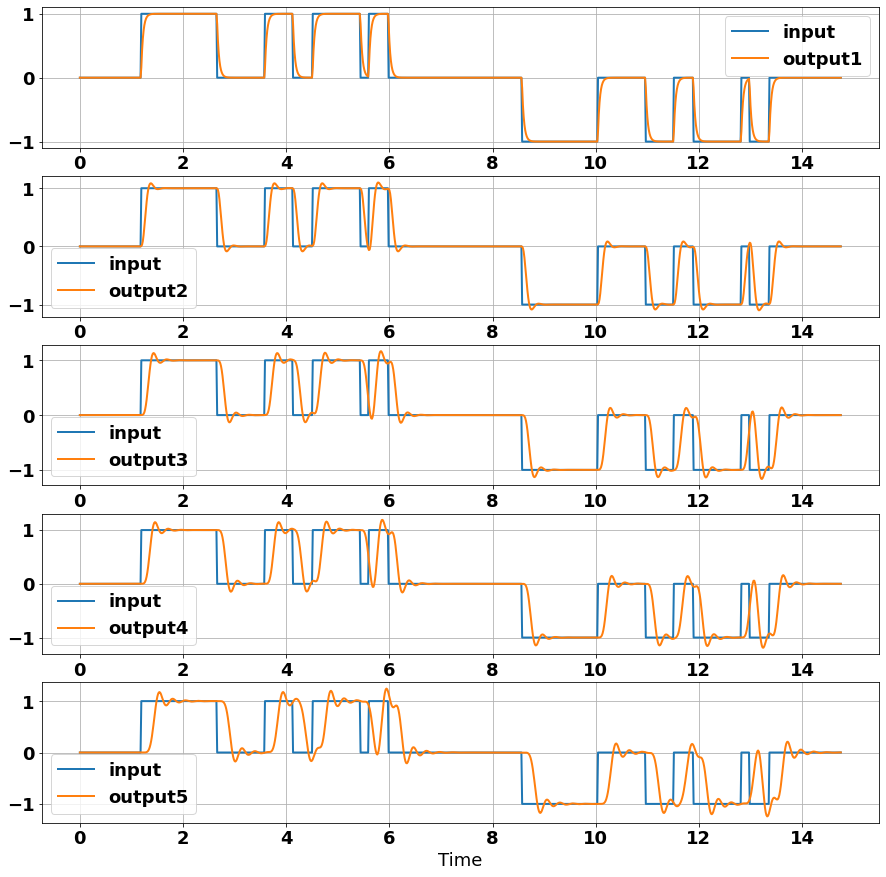

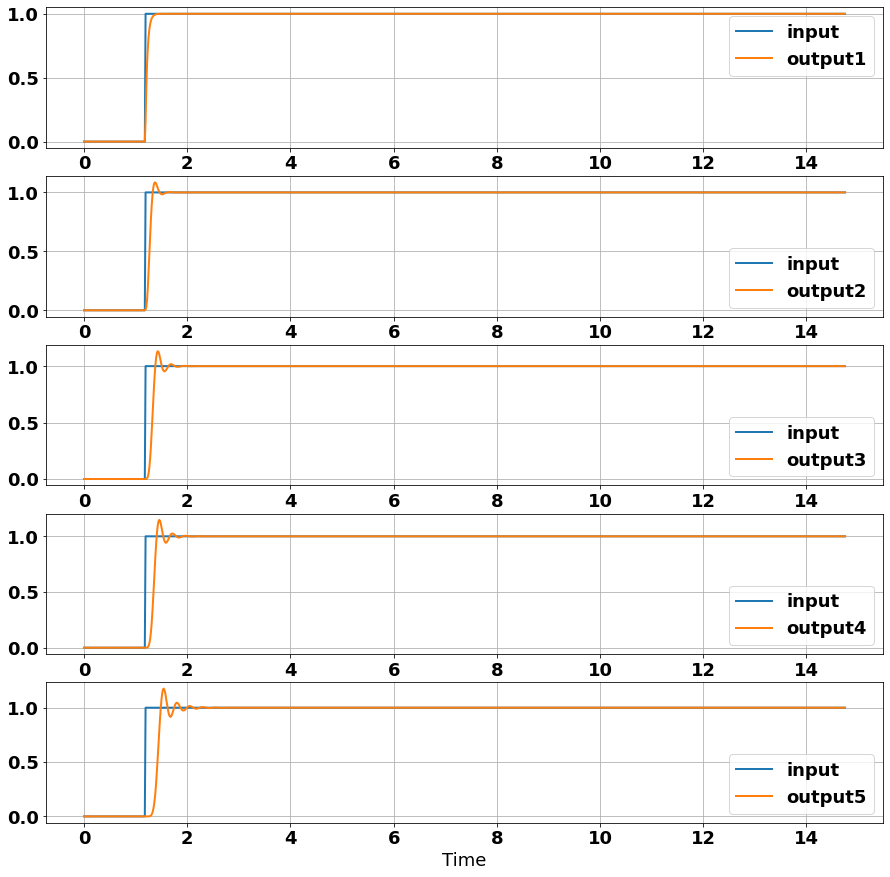

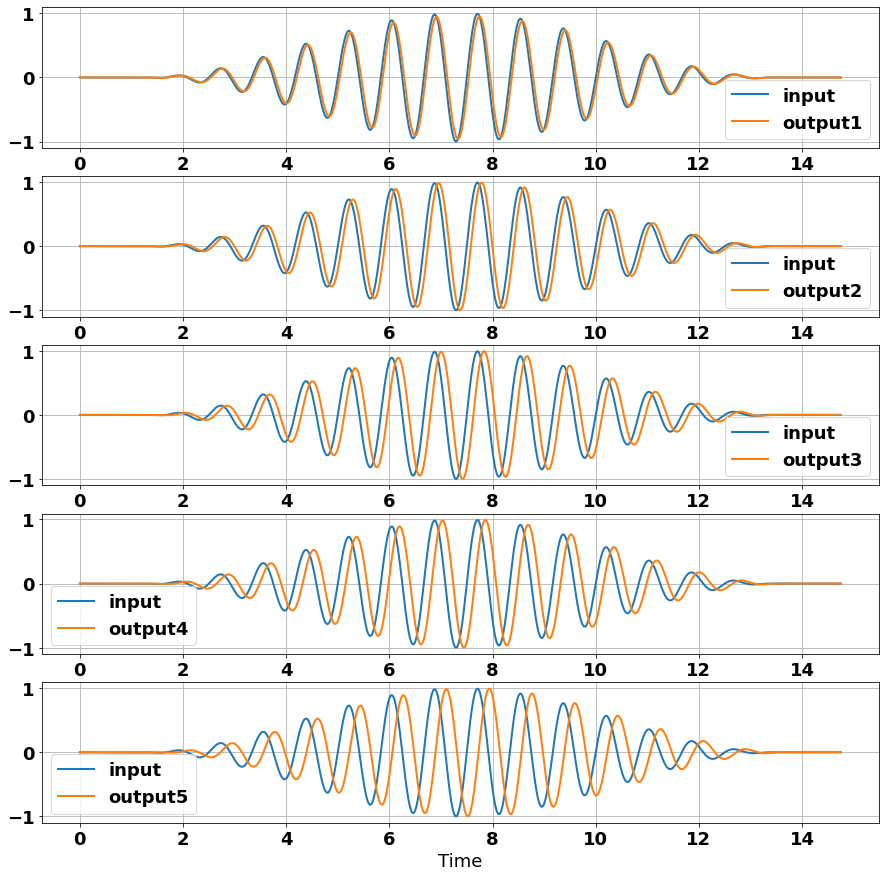

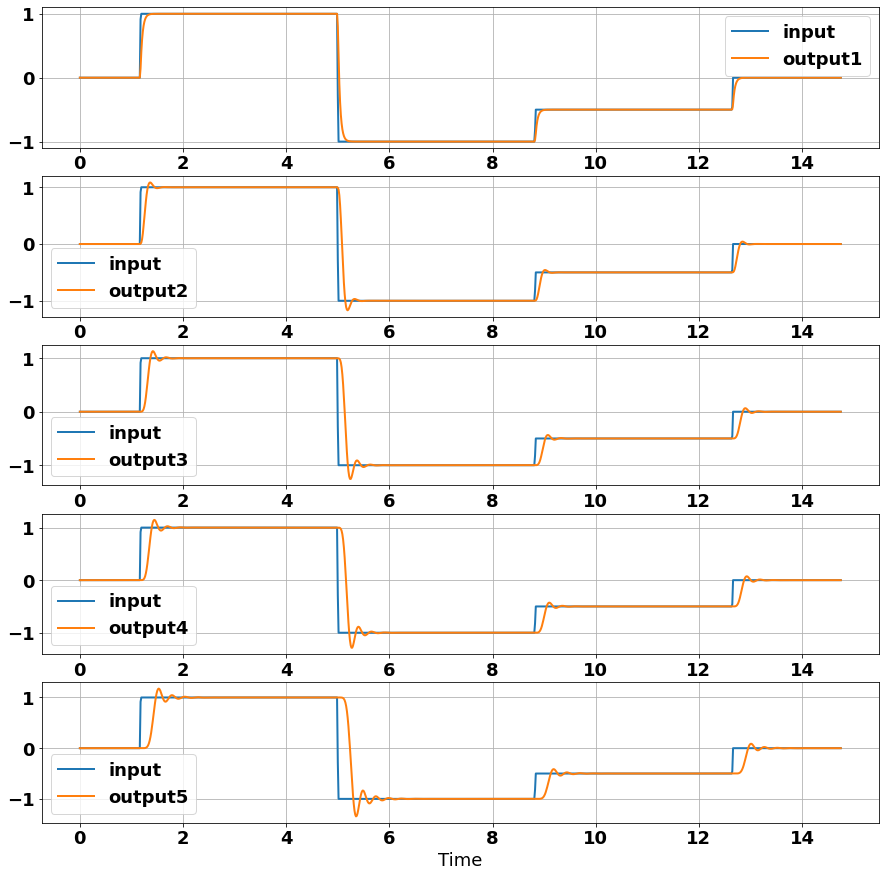

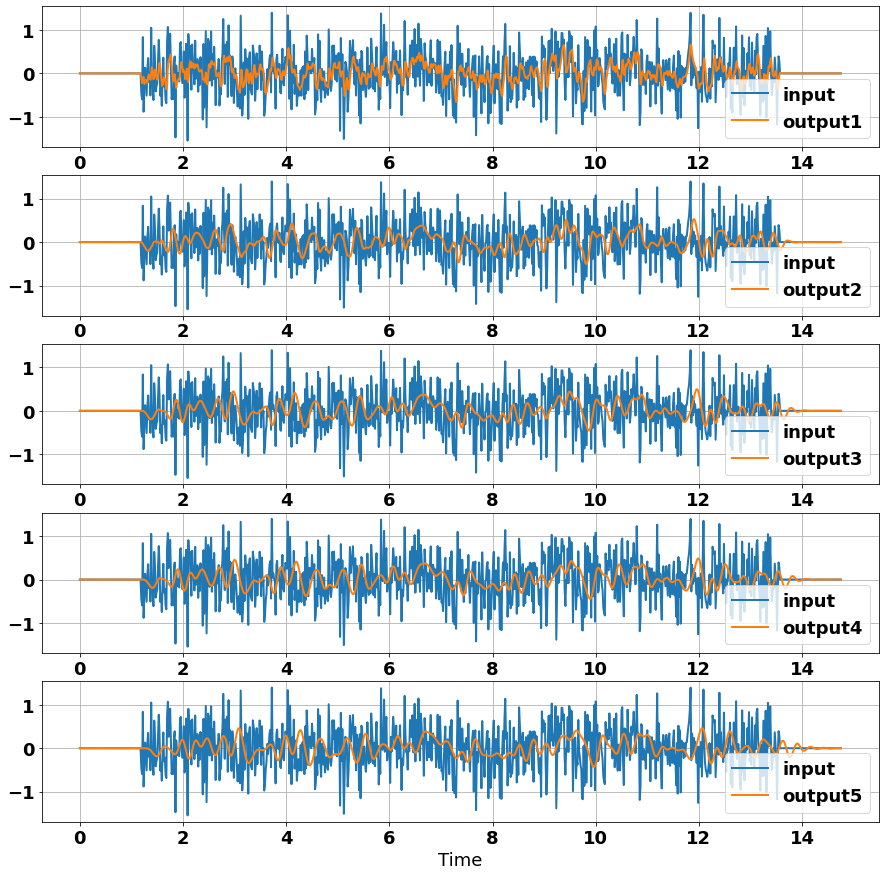

In [130]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')


In [131]:
from sources.utilities.utility_functions import *

t,x,y = load_data_csv("data/DataSet_ex/input1.csv")

# 3. Exemple rudimentaire d'apprentissage <a class="anchor" id="3-bullet"></a>

0. Chargement des modules d'intérêt

In [132]:
import sys
from importlib import reload,import_module
import os

import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

1. On charge ici le modele créé specifiquement

In [133]:
model_definition = "my_model2"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

On peut vérifier grâce aux tests unitaire que le modele est valide pour soumission (NB: il doit calculer cinq sorties pour les cinq grandeurs d'intérêt)

In [134]:
if sys.platform == "win32":
    !python sources/utilities/test_submission.py my_model2
else:
    !python3 sources/utilities/test_submission.py my_model2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 1, 40)        6720        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1, 40)        0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 40)        12960       dropout[0][0]                    
______________________________________________________________________________________________

2021-11-07 19:05:27.672475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-07 19:05:27.672500: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-07 19:05:29.463444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-11-07 19:05:29.463481: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-07 19:05:29.466651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-5UJHVL18
2021-11-07 19:05:29.466732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-5UJHVL18
2021-11-07 19:05:29.467304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is

In [135]:
if sys.platform == 'linux':
    !pygmentize "./sources/utilities/my_model2.py"

2. On selectionne le/les signaux utiles pour l'apprentissage et ceux pour la validation:

2- l'objectif de ce challenge est de construire un modèle qui permette de calculer cinq signaux de sorties (les cinq outputs présentes dans les fichiers que nous vous avons transmis) et qui prenne en entrée un signal d'entrée (la série temporelle input contenue dans chaque fichier). La structure interne de ce modèle est libre. Également, les données d'entraînement peuvent être construites par les candidats : vous avez, par exemple, la possibilité de construire un nouveau fichier csv dédié à l'entraînement de votre modèle à partir d'un traitement de votre choix réalisé sur les données contenues dans les fichiers csv que nous vous avons transmis.

In [146]:
rep_data   = "data/DataSet_phase1/"
liste_df_train = []
for i in range(6):
    file_train = "input" + str(i) + ".csv"
    liste_df_train.append(pd.read_csv(rep_data+file_train))

df_train = pd.concat(liste_df_train)
df_train.head()
df_train.to_csv(path_or_buf = rep_data + "train_data.csv", index=False)

file_train = "train_data.csv"
t_train,x_train,y_train = load_data_csv(rep_data+file_train)

In [147]:
x_train.shape

(34218,)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm_76 (LSTM)                  (None, 1, 40)        6720        input_17[0][0]                   
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 1, 40)        0           lstm_76[0][0]                    
__________________________________________________________________________________________________
lstm_77 (LSTM)                  (None, 1, 40)        12960       dropout_75[0][0]                 
___________________________________________________________________________________________

100/100 [==============================] - 1s 5ms/step - loss: 1.6080 - dense_205_loss: 0.3217 - dense_207_loss: 0.3216 - dense_209_loss: 0.3216 - dense_211_loss: 0.3215 - dense_213_loss: 0.3216
Epoch 21/100
100/100 [==============================] - 0s 5ms/step - loss: 1.5996 - dense_205_loss: 0.3200 - dense_207_loss: 0.3200 - dense_209_loss: 0.3199 - dense_211_loss: 0.3199 - dense_213_loss: 0.3199
Epoch 22/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6685 - dense_205_loss: 0.3337 - dense_207_loss: 0.3337 - dense_209_loss: 0.3337 - dense_211_loss: 0.3337 - dense_213_loss: 0.3336: 0s - loss: 1.6137 - dense_205_loss: 0.3228 - dense_207_loss: 0.3228 - dense_209_loss: 0.3227 - dense_211_loss: 0.3227 - dense_21
Epoch 23/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6158 - dense_205_loss: 0.3232 - dense_207_loss: 0.3232 - dense_209_loss: 0.3232 - dense_211_loss: 0.3231 - dense_213_loss: 0.3231
Epoch 24/100
100/100 [=============================

100/100 [==============================] - 1s 5ms/step - loss: 1.6374 - dense_205_loss: 0.3275 - dense_207_loss: 0.3275 - dense_209_loss: 0.3275 - dense_211_loss: 0.3275 - dense_213_loss: 0.3275
Epoch 57/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6443 - dense_205_loss: 0.3289 - dense_207_loss: 0.3289 - dense_209_loss: 0.3289 - dense_211_loss: 0.3289 - dense_213_loss: 0.3289
Epoch 58/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6407 - dense_205_loss: 0.3281 - dense_207_loss: 0.3281 - dense_209_loss: 0.3281 - dense_211_loss: 0.3281 - dense_213_loss: 0.3281
Epoch 59/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6626 - dense_205_loss: 0.3325 - dense_207_loss: 0.3325 - dense_209_loss: 0.3325 - dense_211_loss: 0.3325 - dense_213_loss: 0.3325
Epoch 60/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6236 - dense_205_loss: 0.3247 - dense_207_loss: 0.3247 - dense_209_loss: 0.3247 - dense_211_loss: 0.324

100/100 [==============================] - 1s 5ms/step - loss: 1.6358 - dense_205_loss: 0.3272 - dense_207_loss: 0.3272 - dense_209_loss: 0.3272 - dense_211_loss: 0.3272 - dense_213_loss: 0.3272
Epoch 95/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6261 - dense_205_loss: 0.3252 - dense_207_loss: 0.3252 - dense_209_loss: 0.3252 - dense_211_loss: 0.3252 - dense_213_loss: 0.3252
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 1.6401 - dense_205_loss: 0.3280 - dense_207_loss: 0.3280 - dense_209_loss: 0.3280 - dense_211_loss: 0.3280 - dense_213_loss: 0.32 - 1s 5ms/step - loss: 1.6384 - dense_205_loss: 0.3277 - dense_207_loss: 0.3277 - dense_209_loss: 0.3277 - dense_211_loss: 0.3277 - dense_213_loss: 0.3277
Epoch 97/100
100/100 [==============================] - 1s 5ms/step - loss: 1.6265 - dense_205_loss: 0.3253 - dense_207_loss: 0.3253 - dense_209_loss: 0.3253 - dense_211_loss: 0.3253 - dense_213_loss: 0.3253
Epoch 98/100
100/100 [===========

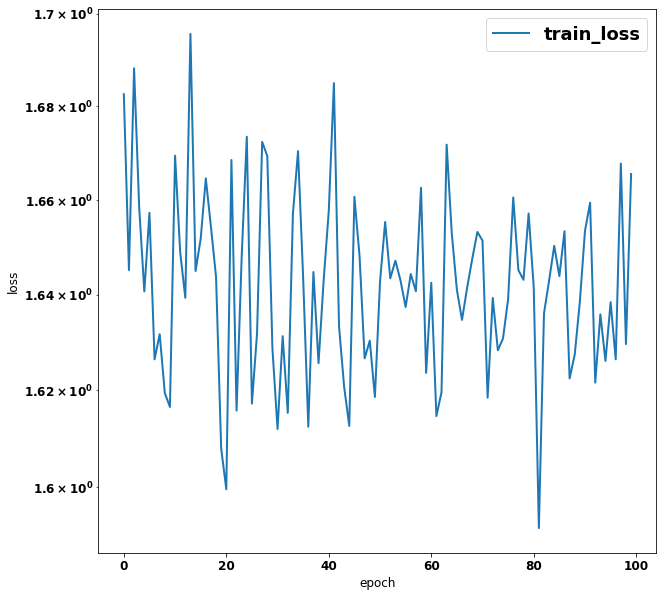

In [148]:
retrain = True

if retrain:
    Ndecim=5
    model = MyModel.create_model(steps_per_epoch=100, batch_size = 50, epochs=100)
    
    history = model.fit(xs=[x_train], ys=y_train)

    
    plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
    plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.show()
    
    retrain = False

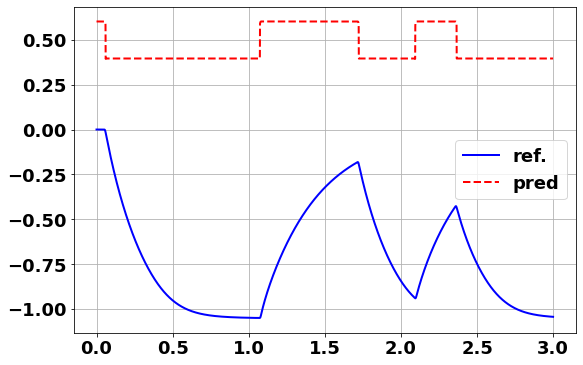

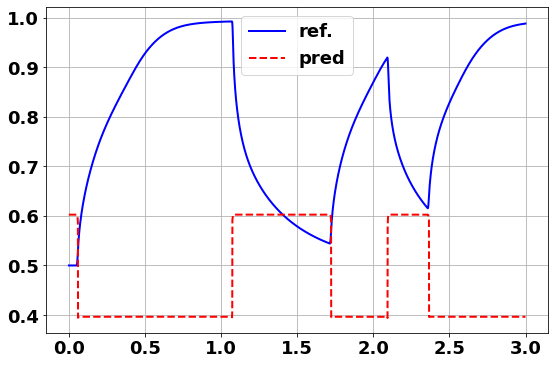

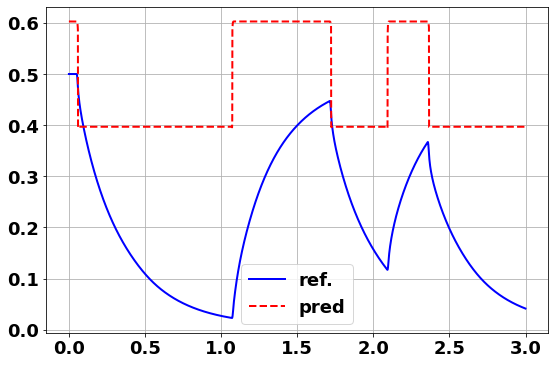

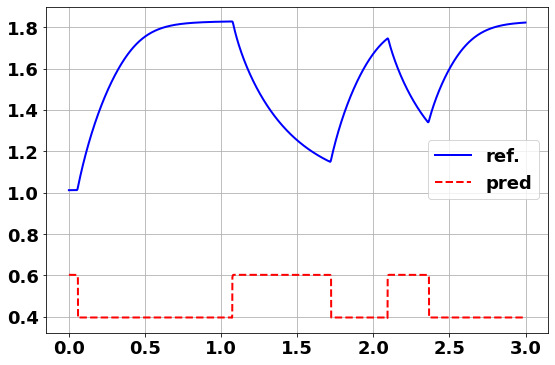

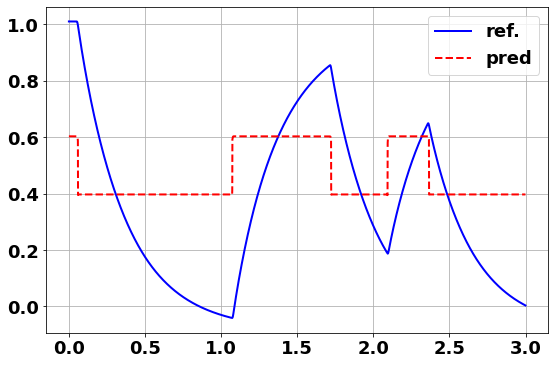

In [149]:
x_train_plt = x_train[:3000]
y_train_plt = y_train[:3000]
t_train_plt = t_train[:3000]
y_pred_train = model.predict_timeseries(x_train_plt.reshape(x_train_plt.shape[0], 1, 1))
for k in range(5):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_train_plt,y_train_plt.T[k],'b', t_train_plt, y_pred_train[:, k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

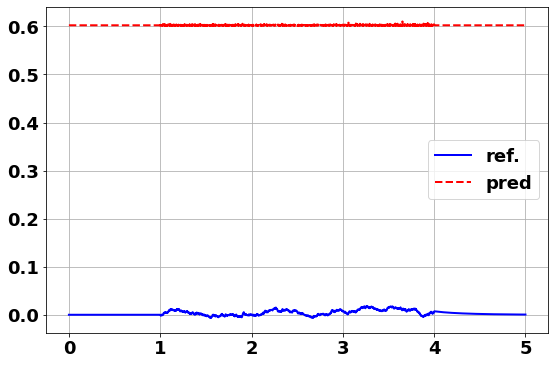

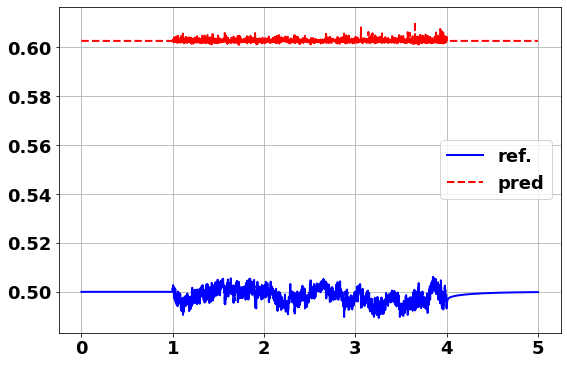

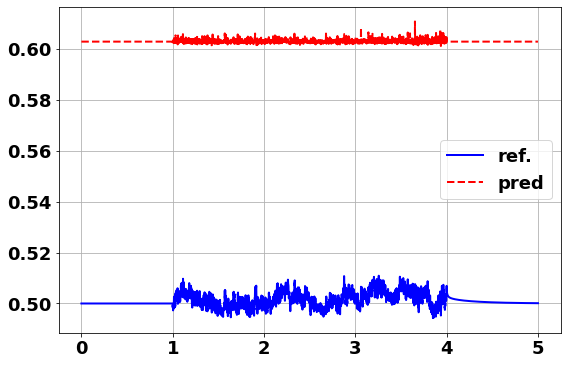

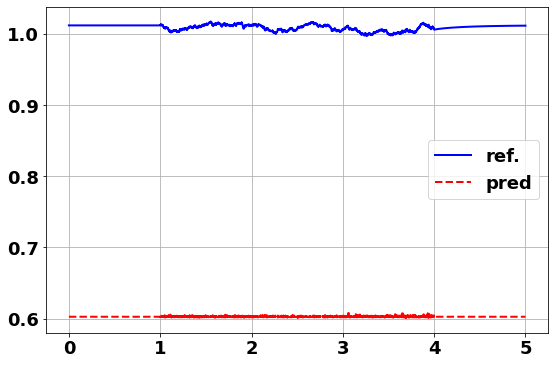

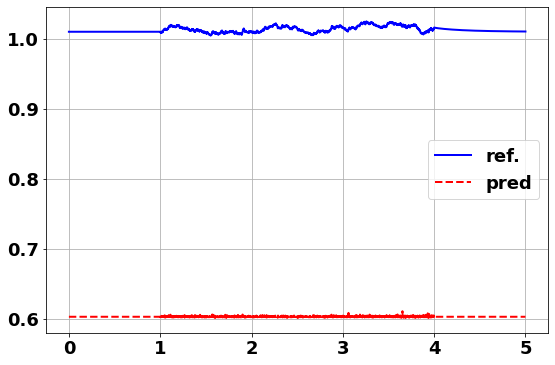

In [150]:
file_test = "input6.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)
x_test = x_test.reshape(x_test.shape[0], 1, 1)

y_pred_test = model.predict_timeseries(x_test.reshape(x_test.shape[0], 1, 1))

for k in range(5):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
#     y_pred_test_k = y_pred_test[k].reshape(y_pred_test[k].shape[0]) 
    ax.plot(t_test,y_test.T[k],'b', t_test, y_pred_test[:, k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

# 4. Lancement sur AWS SageMaker <a class="anchor" id="4-bullet"></a>

0. Test local

Permet de vérifier que tout est ok avant de monter l'image sur une instance amazon (ce qui peut être long)

In [161]:
rep = "data/DataSet_phase1/"
file_train = "train_data.csv"
data = rep + file_train

use_gpu = False
epochs = 40
model_dir = "models/keras_model"
model_name = "keras_model"
lr = 0.005
Ndecim = 5
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"
outputs_prefix='output'

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName\
                              --model_def_file $model_definition --outputs_prefix $outputs_prefix


Failed to load default container env keys. Using local default keys.
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm_94 (LSTM)                  (None, 1, 40)        6720        input_23[0][0]                   
__________________________________________________________________________________________________
dropout_93 (Dropout)            (None, 1, 40)        0           lstm_94[0][0]                    
__________________________________________________________________________________________________
lstm_95 (LSTM)                  (None, 1, 40)        12960       dropout_93[0][0]                 
______________________

300/300 [==============================] - 1s 4ms/step - loss: 0.2739 - dense_271_loss: 0.0992 - dense_273_loss: 0.0135 - dense_275_loss: 0.0142 - dense_277_loss: 0.0700 - dense_279_loss: 0.0771: 0s - loss: 0.2787 - dense_271_loss: 0.1009 - dense_273_loss: 0.0137 - dense_275_loss: 0.0144 - dense_277_loss: 0.0711 - dense_279_loss: 
Epoch 19/40
300/300 [==============================] - 1s 4ms/step - loss: 0.2808 - dense_271_loss: 0.1022 - dense_273_loss: 0.0137 - dense_275_loss: 0.0144 - dense_277_loss: 0.0719 - dense_279_loss: 0.0786
Epoch 20/40
300/300 [==============================] - 1s 4ms/step - loss: 0.2575 - dense_271_loss: 0.0935 - dense_273_loss: 0.0125 - dense_275_loss: 0.0131 - dense_277_loss: 0.0660 - dense_279_loss: 0.0724
Epoch 21/40
300/300 [==============================] - 1s 4ms/step - loss: 0.2751 - dense_271_loss: 0.1001 - dense_273_loss: 0.0134 - dense_275_loss: 0.0141 - dense_277_loss: 0.0702 - dense_279_loss: 0.0773
Epoch 22/40
300/300 [=========================

KeyboardInterrupt: 

In [162]:
t_train,x_train,y_train = load_data_csv(rep+"input0.csv",Ndecim=Ndecim)
file_test  = "input6.csv"

In [163]:
model = MyModel.load(model_dir)

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm_97 (LSTM)                  (None, 1, 40)        6720        input_24[0][0]                   
__________________________________________________________________________________________________
dropout_96 (Dropout)            (None, 1, 40)        0           lstm_97[0][0]                    
__________________________________________________________________________________________________
lstm_98 (LSTM)                  (None, 1, 40)        12960       dropout_96[0][0]                 
___________________________________________________________________________________________

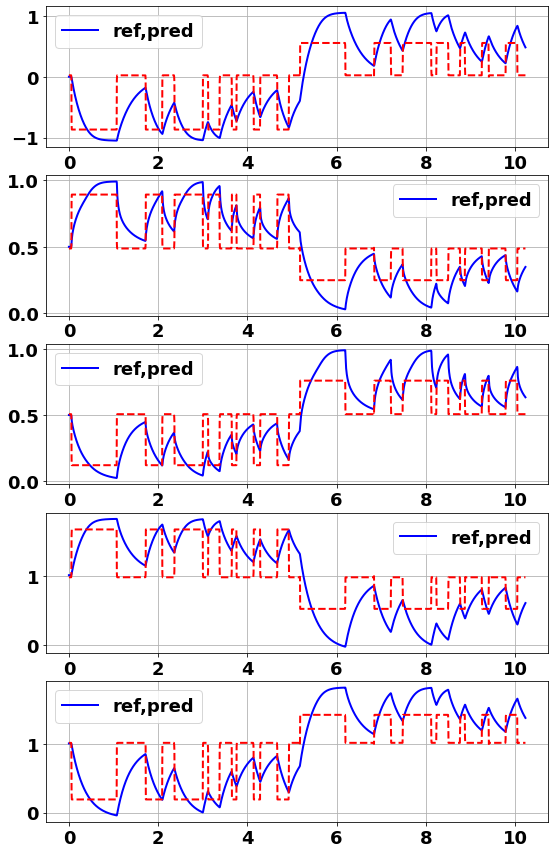

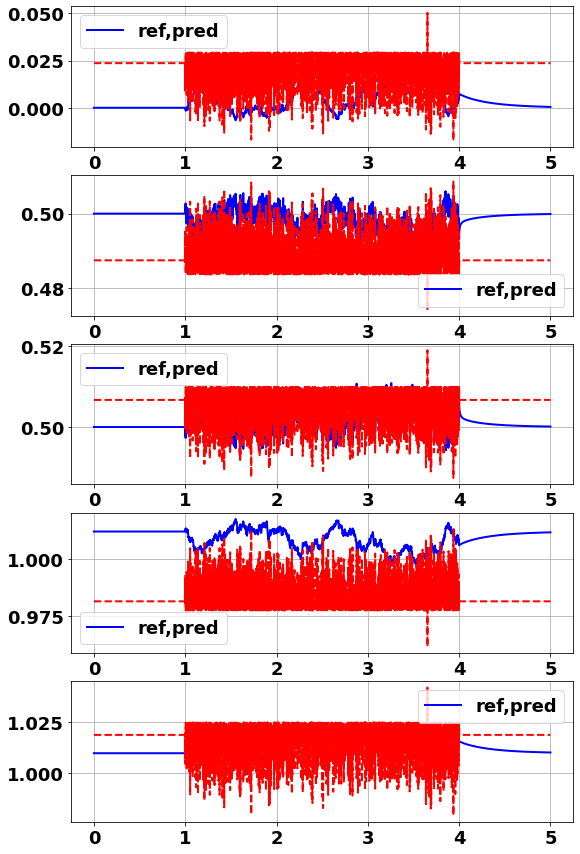

In [164]:
y_pred = model.predict_timeseries(x_train)
No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
#         y_pred_k = y_pred[k].reshape(y_pred[k].shape[0]) 
        ax[k].plot(t_train,y_train[:,outputs_indexes[k]],'b',t_train,y_pred[:, k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[:,outputs_indexes[0]],'b',t_train,y_pred[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])
    
t_test,x_test,y_test = load_data_csv(rep+file_test)
y_pred = model.predict_timeseries(x_test)

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
#         y_pred_k = y_pred[k].reshape(y_pred[k].shape[0]) 
        ax[k].plot(t_test,y_test[:,outputs_indexes[k]],'b',t_test,y_pred[:, k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[:,outputs_indexes[0]],'b',t_test,y_test[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


1. Depôt des données sur S3

In [ ]:
# Define IAM role
role = get_execution_role()
prefix = 'AI4IA-Time-series-forcasting'
containers = {'eu-west-3': 'arn:aws:sagemaker:eu-west-3:433482474488:notebook-instance/ai4ia-time-series-forcasting'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

In [ ]:
bucket_name = 'ai4ia-s3-bucket' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else: 
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

2. Creation des instances et paramétrage de l'estimateur:

In [ ]:
prefix_out = 'AI4IA-Time-series-forcasting/model'
output_path = f's3://'+bucket_name+'/'+prefix_out

In [ ]:
from sagemaker.tensorflow import TensorFlow
framework_version = '2.3'
sagemaker_estimator,framework_version = (TensorFlow, framework_version)

In [31]:
max_run = 60*60*6
hyperparameters = {
    'use_gpu':True,
    'epochs':350,
    'lr':.005,
    'Ndecim':5,
    'train_fileName':file_train,
    'model_def_file':'keras_model',
    'outputs_prefix':'output'
}
estimator = TensorFlow(
    entry_point="sagemaker_api.py",
    source_dir="sources",
    hyperparameters=hyperparameters,
    role=role,
    framework_version=framework_version,
    py_version="py37",
    max_run=max_run,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    output_path=output_path
)
estimator.fit()

In [ ]:
training_job_name = estimator.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
trained_model_location = desc['ModelArtifacts']['S3ModelArtifacts']
display('Model is here: {}'.format(trained_model_location))

s3 = boto3.resource('s3')    
s3.Bucket(bucket).download_file(prefix_out + '/' + desc['TrainingJobName'] + '/' + 'output/model.tar.gz','./models/model.tar.gz')

In [34]:
model_dir = './models/keras_model'

with tarfile.open('./models/keras_model.tar.gz','r:gz') as archived:
    archived.extractall(model_dir)

In [35]:
model = MyModel.load(model_dir)

In [ ]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[:,outputs_indexes[:,k]],'b',t_train,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[:,outputs_indexes[0]],'b',t_train,y_pred[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])


In [ ]:
from sklearn.metrics import mean_squared_error


y_pred = model.predict_timeseries(x_test)
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
max_ytest_value = np.zeros( (No,) )
for k in range(No) : # PLEASE NOTE THAT WE ONLY CONSIDER MODELS THAT COMPUTES ALL THE 5 OUTPUTS
    max_ytest_value[k] = np.max(np.abs(y_test[:,k]))

metric_normalized_mse = np.zeros( (No,) )
for k in range(No):
    metric_normalized_mse[k] = mean_squared_error(y_true=y_test[:,k]/max_ytest_value[k],y_pred=y_pred[:,k]/max_ytest_value[k])

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[:,outputs_indexes[:,k]],'b',t_test,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
        ax[k].set_title("MSE Normalized Error = {:01.7f}".format(metric_normalized_mse[k]))
else:
    ax.plot(t_test,y_test[:,outputs_indexes[0]],'b',t_test,y_test[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    ax.set_title("MSE Normalized Error = {:01.7f}".format(metric_normalized_mse[0]))
    
plt.show()

# 5. Evaluation des solutions <a class="anchor" id="5-bullet"></a>

0. Recuperation des paramètres (modele et entraînement)

In [166]:
with open("./models/keras_model/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/keras_model/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [167]:
dHyper,dKwargs

({'model_dir': 'models/keras_model',
  'data_dir': 'data/DataSet_phase1/',
  'model_def_file': 'my_model2',
  'epochs': 40,
  'lr': 0.005,
  'outputs_indexes': '1,2,3,4,5',
  'hyper_fileName': 'hyper.json',
  'use_gpu': True,
  'train_fileName': 'train_data.csv',
  'Ndecim': 5,
  'outputs_prefix': 'output'},
 {'epochs': 40, 'lr': 0.005, 'output_size': 5})

1. Local metric tests

In [168]:
keras_model = MyModel(**dKwargs)

In [169]:
data_dir = "./data/DataSet_phase1"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input6.csv'
model_dir       = './models/keras_model'
model_def_file  = 'my_model2'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


./models/keras_model\hyper.json
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm_100 (LSTM)                 (None, 1, 40)        6720        input_25[0][0]                   
__________________________________________________________________________________________________
dropout_99 (Dropout)            (None, 1, 40)        0           lstm_100[0][0]                   
__________________________________________________________________________________________________
lstm_101 (LSTM)                 (None, 1, 40)        12960       dropout_99[0][0]                 
___________________________________________________________

300/300 [==============================] - 1s 4ms/step - loss: 0.2766 - dense_293_loss: 0.1005 - dense_295_loss: 0.0135 - dense_297_loss: 0.0142 - dense_299_loss: 0.0708 - dense_301_loss: 0.0777
Epoch 19/40
300/300 [==============================] - 1s 4ms/step - loss: 0.2640 - dense_293_loss: 0.0961 - dense_295_loss: 0.0128 - dense_297_loss: 0.0135 - dense_299_loss: 0.0675 - dense_301_loss: 0.0741: 0s - loss: 0.2642 - dense_293_loss: 0.0963 - dense_295_loss: 0.0128 - dense_297_loss: 0.0137 - dense_299_loss: 0.0673 
Epoch 20/40
300/300 [==============================] - 1s 4ms/step - loss: 0.2790 - dense_293_loss: 0.1014 - dense_295_loss: 0.0136 - dense_297_loss: 0.0144 - dense_299_loss: 0.0714 - dense_301_loss: 0.0783
Epoch 21/40
300/300 [==============================] - 1s 4ms/step - loss: 0.2758 - dense_293_loss: 0.1003 - dense_295_loss: 0.0135 - dense_297_loss: 0.0142 - dense_299_loss: 0.0708 - dense_301_loss: 0.0770
Epoch 22/40
300/300 [==============================] - 1s 4ms/st

In [170]:
with open('./metrics/Guan_Li_DSIA_5012B_Keras_model_metrics','r') as f: print(f.read())

affiliation : ESIEE Paris
description : LSTM
email : xianli.li@edu.esiee.fr
model_name : Keras_model
model_title : Keras Model LSTM
other_remarks : 
team_name : Guan_Li_DSIA_5012B
technology_stack : Keras
Aggregated Metrics : 0.9374238807065084
Average inference time [seconds] : 0.029333552463701597
Entire series inference time [seconds] : 146.69709587097168
Maximal inference time [seconds] : 0.7626471519470215
Normalized MSE : [1.37769498e-01 1.63672812e-04 3.29847534e-04 2.10180476e-05
 3.00382502e-04]
Normalized MSE Sum : 0.13858441894106235
Training set size : 6844
Training time [seconds] : 53.126477003097534



In [171]:
pwd

'C:\\Users\\lixia\\Documents\\esiee\\E5\\Time series\\AI4IA_phase1_python'

2. AWS Metrics tests

In [50]:
metrics_dir = './metrics_sage'
model_def_file = "my_model2"
type_instance = 'ml.m5.4xlarge' # Mention that the time limit is t on this specific type of instance

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

2021-10-27 09:48:22 Starting - Starting the training job...
2021-10-27 09:48:45 Starting - Launching requested ML instancesProfilerReport-1635328101: InProgress
...
2021-10-27 09:49:16 Starting - Preparing the instances for training............
2021-10-27 09:51:06 Downloading - Downloading input data...
2021-10-27 09:51:46 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:51:58,202 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-27 09:51:58,205 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-27 09:51:58,218 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-27 09:51:58,865 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-27 09:51:59,277 sagemaker-training-toolkit INFO     No GPUs detected (normal 

In [55]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU1' + '_metrics'),'r') as f:  print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU1
other_remarks : 
team_name : s2m
technology_stack : pytorch
Aggregated Metrics : 3.0958937816105667
Average inference time [seconds] : 0.0009050564765930175
Entire series inference time [seconds] : 0.9050564765930176
Maximal inference time [seconds] : 0.004453420639038086
Normalized MSE : [0.36984636 0.62093299 0.64192965 0.86716029 0.59066486]
Normalized MSE Sum : 3.0905341448453783
Training time [seconds] : 4.17473840713501



In [52]:
metrics_dir = './metrics_sage'
model_def_file = "my_model2"

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

2021-10-27 09:53:07 Starting - Starting the training job...
2021-10-27 09:53:30 Starting - Launching requested ML instancesProfilerReport-1635328386: InProgress
......
2021-10-27 09:54:33 Starting - Preparing the instances for training.........
2021-10-27 09:55:51 Downloading - Downloading input data...
2021-10-27 09:56:31 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-27 09:56:49,518 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-27 09:56:49,521 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-27 09:56:49,534 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2021-10-27 09:57:09 Uploading - Uploading generated training model2021-10-27 09:56:55,759 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-27 09:56:

In [56]:
with open(os.path.join(metrics_dir,"Guan_Li_DSIA_5012B_Keras_model_metrics"),'r') as f:  print(f.read())

affiliation : SKF Group
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : francois.caire@skf.com
model_name : GRU2
other_remarks : 
team_name : s2m
technology_stack : pytorch
Aggregated Metrics : 6.881637116049163
Average inference time [seconds] : 0.0009189200401306152
Entire series inference time [seconds] : 0.9189200401306152
Maximal inference time [seconds] : 0.001825094223022461
Normalized MSE : [1.67763833 1.40341474 1.30848855 1.28328809 1.20606159]
Normalized MSE Sum : 6.87889129578236
Training time [seconds] : 6.501613140106201



In [58]:
if sys.platform=='linux':
    !pipreqs ./ --force